In [12]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import  estimateNorm
from LSSVM import predict, accuracy, linearKernel
from VQLSSVM import VQLSSVM

In [13]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
subsetSize: int = 7
classToFilterOut: int = 2

In [14]:
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris") -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    else: 
        raise ValueError("Dataset not yet implemented")
    
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues:
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=42)

In [15]:
vqlssvm: VQLSSVM = VQLSSVM(gamma, shots)

In [16]:
xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="iris")

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00444383e+02 -6.22587902e-01  4.71487014e-01
   4.89180724e-01 -8.99129704e-01  4.99331734e-01  5.45317625e-01]
 [ 1.00000000e+00 -6.22587902e-01  1.01274288e+02 -2.73963355e-01
  -7.85781241e-01  1.46337081e+00 -6.68600527e-01 -1.13960908e+00]
 [ 1.00000000e+00  4.71487014e-01 -2.73963355e-01  1.01283470e+02
   2.98786123e-01 -9.70164094e-01  5.65528259e-01 -7.41627048e-02]
 [ 1.00000000e+00  4.89180724e-01 -7.85781241e-01  2.98786123e-01
   1.00606526e+02 -9.66710435e-01  5.39564093e-01  7.79402254e-01]
 [ 1.00000000e+00 -8.99129704e-01  1.46337081e+00 -9.70164094e-01
  -9.66710435e-01  1.02049733e+02 -9.98706676e-01 -1.14751639e+00]
 [ 1.00000000e+00  4.99331734e-01 -6.68600527e-01  5.65528259e-01
   5.39564093e-01 -9.98706676e-01  1.00563604e+02  5.79820896e-01]
 [ 1.00000000e+00  5.45317625e-01 -1.13960908e+00 -7.4

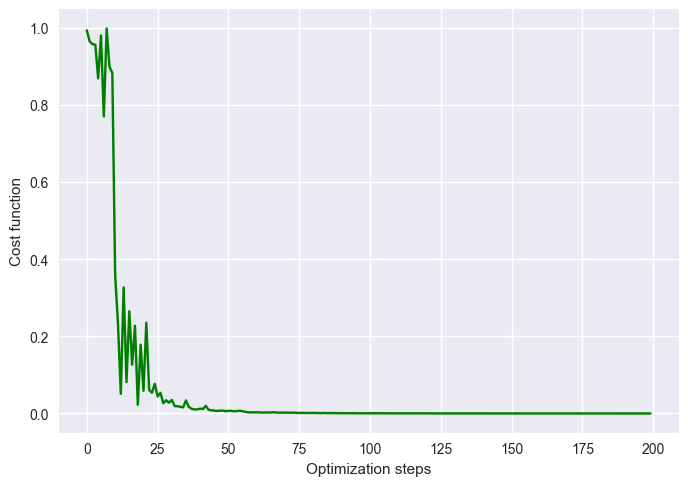

In [17]:
vqlssvm.train(xTrain, yTrain, quantumSimulation=False, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [18]:
print(vqlssvm.predict(xTest))

[ 0.03036696+0.j  0.02738474+0.j  0.0168077 +0.j -0.0172423 +0.j
 -0.03024576+0.j -0.0247608 +0.j -0.03597045+0.j  0.0225456 +0.j
 -0.03015237+0.j -0.02785621+0.j -0.02884932+0.j -0.0186331 +0.j
  0.02361003+0.j -0.04212279+0.j  0.02274766+0.j -0.03077757+0.j
  0.02928836+0.j  0.0269914 +0.j -0.0182499 +0.j -0.02206695+0.j
  0.02039322+0.j  0.01216804+0.j -0.02357915+0.j -0.02544912+0.j
  0.02148454+0.j -0.04397343+0.j -0.02865063+0.j  0.01582554+0.j
 -0.01931095+0.j  0.03479569+0.j -0.02571092+0.j -0.02358881+0.j
  0.00943523+0.j -0.02493485+0.j  0.01790997+0.j -0.03239105+0.j
  0.01612019+0.j  0.01870391+0.j -0.02281275+0.j -0.03533559+0.j
 -0.02369975+0.j -0.01880715+0.j -0.02532289+0.j  0.01296246+0.j
 -0.02655799+0.j -0.0336941 +0.j  0.02130566+0.j -0.01514966+0.j
  0.03104304+0.j -0.02326873+0.j -0.02350251+0.j -0.0204934 +0.j
 -0.02735241+0.j -0.02073057+0.j -0.01763516+0.j  0.0207278 +0.j
 -0.02780356+0.j  0.01084664+0.j -0.02634401+0.j  0.02266619+0.j
  0.01495303+0.j  0.01744

In [19]:
 print("Accuracy:",vqlssvm.accuracy(xTest, yTest))

Accuracy: 1.0


LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00444383e+02 -6.22587902e-01  4.71487014e-01
   4.89180724e-01 -8.99129704e-01  4.99331734e-01  5.45317625e-01]
 [ 1.00000000e+00 -6.22587902e-01  1.01274288e+02 -2.73963355e-01
  -7.85781241e-01  1.46337081e+00 -6.68600527e-01 -1.13960908e+00]
 [ 1.00000000e+00  4.71487014e-01 -2.73963355e-01  1.01283470e+02
   2.98786123e-01 -9.70164094e-01  5.65528259e-01 -7.41627048e-02]
 [ 1.00000000e+00  4.89180724e-01 -7.85781241e-01  2.98786123e-01
   1.00606526e+02 -9.66710435e-01  5.39564093e-01  7.79402254e-01]
 [ 1.00000000e+00 -8.99129704e-01  1.46337081e+00 -9.70164094e-01
  -9.66710435e-01  1.02049733e+02 -9.98706676e-01 -1.14751639e+00]
 [ 1.00000000e+00  4.99331734e-01 -6.68600527e-01  5.65528259e-01
   5.39564093e-01 -9.98706676e-01  1.00563604e+02  5.79820896e-01]
 [ 1.00000000e+00  5.45317625e-01 -1.13960908e+00 -7.4

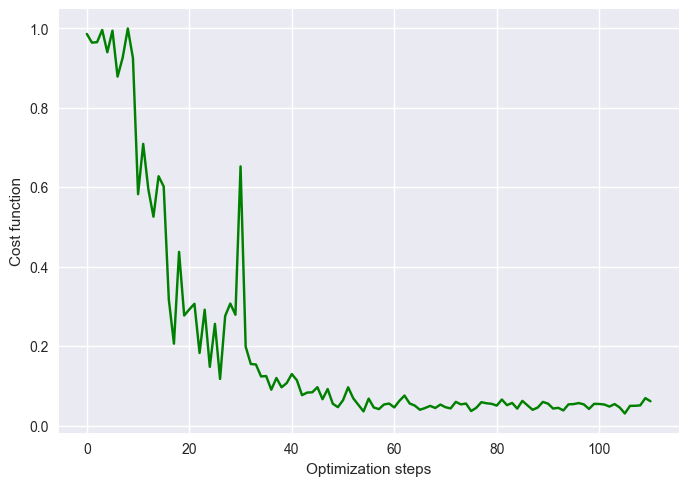

In [20]:
vqlssvm.train(xTrain, yTrain, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [21]:
print("Predictions: ", vqlssvm.predict(xTest))
print("Accuracy: ", vqlssvm.accuracy(xTest, yTest))
# condition number of the matrix

Predictions:  [ 0.0298496 +0.j  0.02212552+0.j  0.01620804+0.j -0.03868189+0.j
 -0.05084067+0.j -0.04734018+0.j -0.060315  +0.j  0.01500168+0.j
 -0.05318311+0.j -0.05087204+0.j -0.05066883+0.j -0.04049225+0.j
  0.01870801+0.j -0.06624321+0.j  0.01727143+0.j -0.05397813+0.j
  0.02635454+0.j  0.02661205+0.j -0.04126887+0.j -0.04301554+0.j
  0.01567462+0.j  0.00602169+0.j -0.04432743+0.j -0.04835099+0.j
  0.01405904+0.j -0.06654652+0.j -0.05116277+0.j  0.01013277+0.j
 -0.04221152+0.j  0.03333751+0.j -0.04807285+0.j -0.04618755+0.j
  0.00613157+0.j -0.04776596+0.j  0.00831397+0.j -0.05363987+0.j
  0.01262865+0.j  0.01417473+0.j -0.04588066+0.j -0.05765986+0.j
 -0.04639753+0.j -0.04091803+0.j -0.0479194 +0.j  0.00631242+0.j
 -0.04928782+0.j -0.05615415+0.j  0.0127032 +0.j -0.03680695+0.j
  0.02366802+0.j -0.04717997+0.j -0.04505785+0.j -0.04265569+0.j
 -0.04957855+0.j -0.04329726+0.j -0.0397654 +0.j  0.0174724 +0.j
 -0.04994779+0.j  0.00352356+0.j -0.04956015+0.j  0.01707179+0.j
  0.0124060